## 1. Opérateur de convolution

$ y(n) = \{ x \star h \}(n) = \sum_{p\in Z} x(p)h(n-p)$

- Opérateur linéraire et invariant par décalage 
- Element neutre :  $\delta(n) $ ($\delta(0)=1$ et $\delta(n)=0$ pour $n\neq0$) : $\{ x \star \delta \}(n) = x(n)$
- Equivaut à une multiplication dans le domaine fréquentiel : $Y(f) = X(f)H(f)$ avec Y, X, H les TF des signaux   
- Convolution <=> Filtrage discret, avec h la réponse impulsionnelle du filtre.

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log


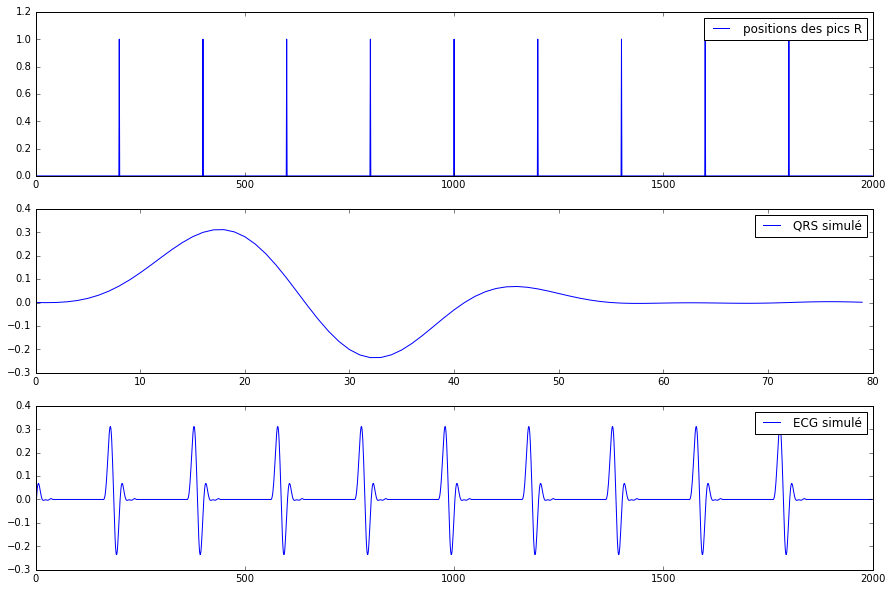

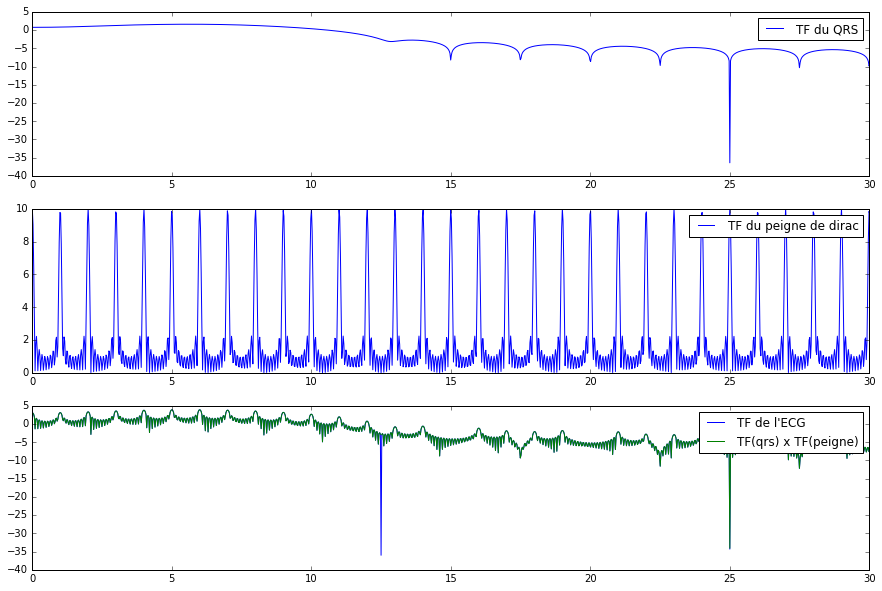

In [ ]:
import numpy as np
import scipy.signal as sig
from matplotlib.pylab import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

def simulate_qrs(duration, fs):
    #simule la forme d'onde d'un complexe QRS avec une wavelet.
    qrs = sig.wavelets.daub(5) 
    return sig.resample(qrs * sig.windows.hann(len(qrs)), int(duration*fs))

def simulate_ecg(RRDuration, totalDuration, fs, doPlots = False):
    
    RR = np.concatenate(([1],np.zeros(int(RRDuration * fs)-1))) # un dirac de longueur RR
    RRpositions = np.tile(RR, totalDuration//RRDuration) # un peigne de dirac de longueur la taille de l'ECG
    qrs = simulate_qrs(0.4, fs) # le QRS simule
    ecg = np.convolve(RRpositions, qrs , 'full') # la convolution du peigne avec le QRS donne l'ECG
    
    if doPlots:
        
        subplot(311),    plot(RRpositions, label='positions des pics R'),ylim([0,1.2]), legend()
        subplot(312),    plot(qrs, label='QRS simulé'),legend()
        subplot(313),    plot(np.convolve(qrs, RRpositions , 'same'), label='ECG simulé'),legend()
                
        # observons le spectre d'un QRS
        figure()
        NFFT = 8096
        freqs = np.arange(0,NFFT/2+1)*fs/NFFT # l'axe des frequences va de 0 a FS/2 Hz. 
        winfunc = np.ones # fonction de fenetrage utilise dans la FFT
        QRS = np.fft.rfft(qrs * winfunc(len(qrs)), NFFT ) # FFT(qrs)
        ax2 = subplot(311)
        plot(freqs, np.log(abs(QRS)), label ='TF du QRS'), legend()
        
        COMB = np.fft.rfft(RRpositions * winfunc(len(RRpositions)), NFFT) # FFT(COMB)
        subplot(312,sharex = ax2),plot(freqs, abs(COMB) ,label ='TF du peigne de dirac'), legend()
        
        ECG = np.fft.rfft(ecg * winfunc(len(ecg)), NFFT) #FFT(ECG)
        subplot(313,sharex=ax2),plot(freqs, np.log(abs(ECG)), label ='TF de l\'ECG')
        plot(freqs, np.log(abs(COMB * QRS)), label='TF(qrs) x TF(peigne)' ), legend()
        xlim([0,30])
        show()
  
    return ecg                    
                        
ecg = simulate_ecg(1, 10, 200, True)

## 2. Exemples de filtres simples 

On ajoute une baseline artificielle, à 0.01 Hz

C:\Anaconda3\lib\site-packages\numpy\lib\shape_base.py:873: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return c.reshape(shape_out)


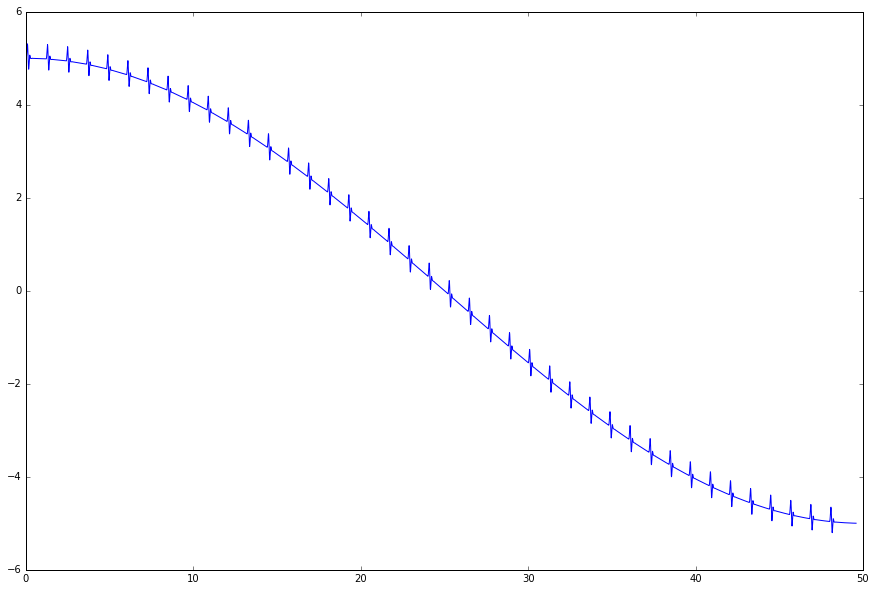

In [32]:
# ECG de 50 RRs espacés de 1.2 sec, échantillonné à 200 Hz
fs = 200
intervalRR = 1.2
nbQRS = 50
ecg = simulate_ecg(intervalRR, nbQRS, fs)
time = np.arange(0, len(ecg)/fs, 1/fs) # axe du temps, echantillonne a FS
baseline =  5 * np.cos(2 * pi * time * 0.01) # baseline de 0.1 Hz

# on ajoute la baseline artificielle : 
ecg_avec_baseline = ecg  + baseline
plot(time, ecg_avec_baseline)

### 2.1 Filtre passe-bas
On va bien sûr chercher à enlever cette baseline. Une idée pourrait être de faire une moyenne glissante des N derniers échantillons ; celle-ci donnant une valeur probable de la tendance du signal, qu'il suffira ensuite de retirer. On note $y$ la moyenne glissante : 

$ y(n) = \frac{x(n) + x(n-1) + \dots + x(n-N+1)}{N}$

ou encore, comme une convolution : 

$ y(n) = N^{-1} \sum_{p=0}^{N-1} x(n-p) =  \sum_{p=0}^{N-1} x(n-p) h(p)$

avec $h(n) = (N^{-1}) \mathbb{1}_{[0,N-1]}(n) $




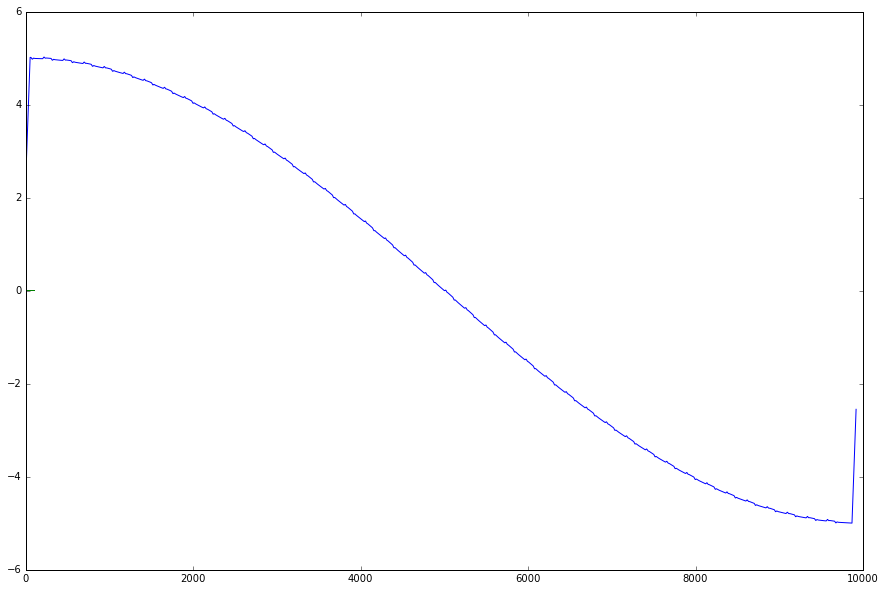

In [34]:
duration = 1/2 # cf plus loin
N = int(duration*fs) # N = 1000 échantillons ici
h = (1/N) * np.ones(N)
y = np.convolve(ecg_avec_baseline,h,'same')
plot(y)
plot(h)

On retrouve la baseline. 
Il s'agit d'une filtre passe-bas (= lissage). Observons la réponse impulsionnelle $h$ de ce filtre, et sa réponse en fréquence :

([<matplotlib.lines.Line2D at 0x1f495db8358>],
 (0, 8.0),
 (-50, 0),
 ([<matplotlib.axis.XTick at 0x1f495dc27b8>,
  <a list of 4 Text xticklabel objects>),
 <matplotlib.text.Text at 0x1f495dbde80>)

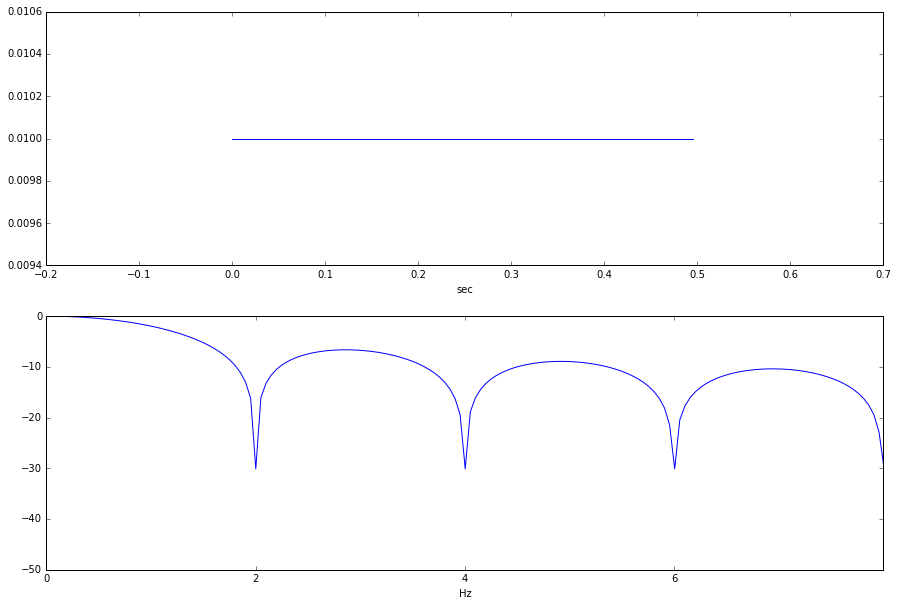

In [35]:
NFFT = 4096
subplot(211)
plot(np.arange(0,len(h))/fs,h),xlim([-0.2,duration+0.2]),xlabel('sec') # reponse impulsionnelle de h
subplot(212)
freq = np.arange(0,NFFT/2+1)*fs/NFFT 
H = np.fft.rfft(h,NFFT) # H est la reponse en frequence de h.
plot(freq,10*log10(abs(H+1.e-19))),xlim([0,4/duration]),ylim([-50,0]),xticks(np.arange(0,4/duration,1/duration)),xlabel('Hz')

On laisse bien passer le signal qui se trouve avant 0.2 Hz  (et on annule les multiples de $f = 1/\text{longueur du filtre}$
).


### 2.2. Filtre passe-haut


A présent il faut retirer cette baseline du signal original, afin d'obtenir un ECG droit. 
On note $e$ l'ecg d'origine, et $\hat{e}$ le signal estimé. Alors : 

$ \hat{e}(n) = e(n) -  \{ e \star h \}(n)$ 

$ \hat{e}(n) = e(n) - \sum_{p \in Z} e(p) h(n-p) = \{ e \star \delta \}(n) - \sum_{p \in Z} e(p) h(n-p)$ (delta élément neutre)

$ \hat{e}(n) = \sum_{p \in Z} e(p) \delta(n-p) - \sum_{p \in Z} e(p) h(n-p) = \sum_{p \in Z} e(p) [\delta-h](n-p)$

Soit en notant $ g(n) = [\delta-h](n) $ : 

$ \hat{e}(n) = \{ e \star g \}(n)$

Que vaut $g$ ? 

- Pour $n\neq0$, $ g(n) = -h(n) $ car $\delta$ est nulle par définition
- Pour $n=0$, $g(0) = 1 - h(0)$

(0, 2000)

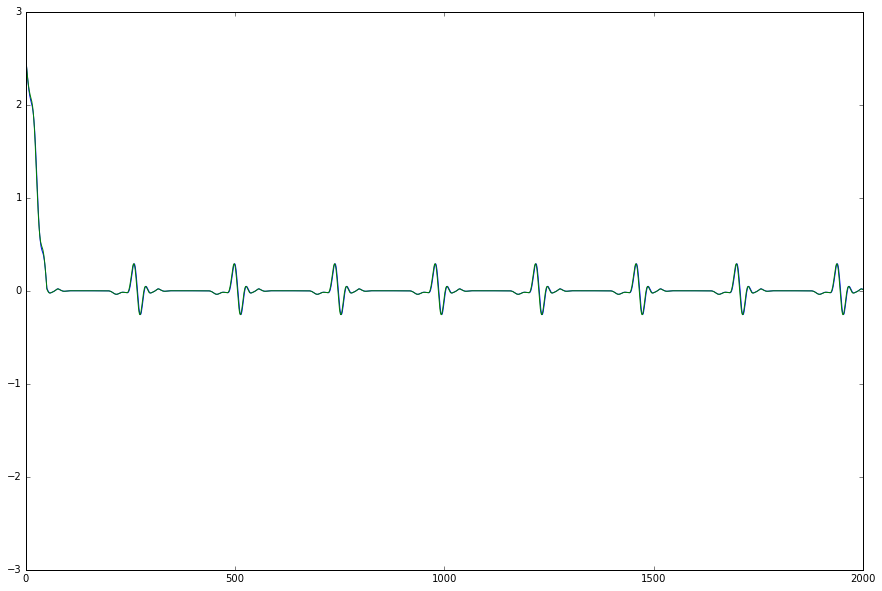

In [36]:
g = - h
g[N//2] = 1 - h[N//2] # les filtres FIR sont centres en 0, la position "0" est donc N/2 
y2 = np.convolve(ecg_avec_baseline,g,'same')

plot(y2)
plot(ecg_avec_baseline - y )
xlim([0,2000])

(-100, 2)

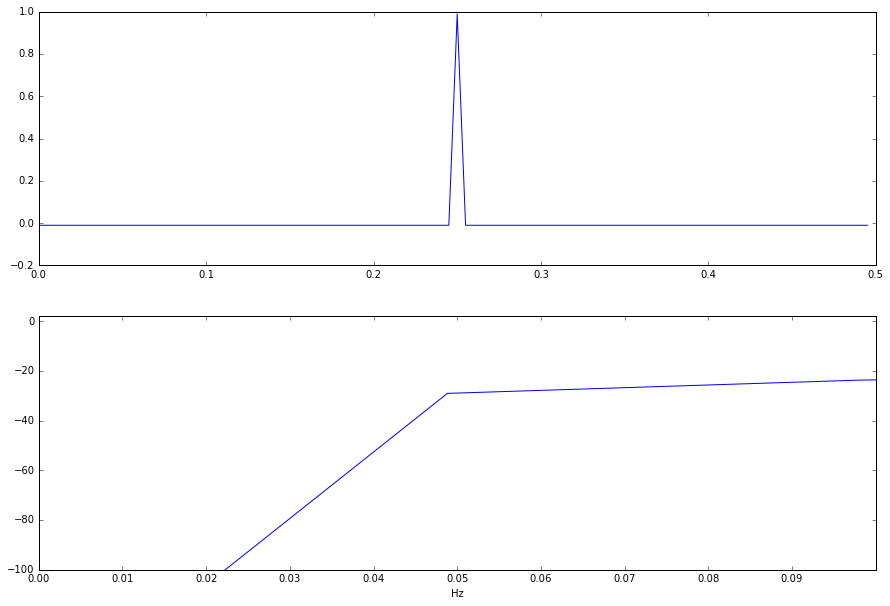

In [53]:
subplot(211)
plot(np.arange(0,len(h))/fs,g)
subplot(212)
G = np.fft.rfft(g, NFFT)
plot(freq,10*log10(abs(G+1.e-19)))
xlim([0,0.1])
xticks(np.arange(0,0.1,0.01)),xlabel('Hz')
ylim([-100,2])

On a bien enleve la baseline a 0.01 Hz

### 2.3 Filtre coupe-bande 

On ajoute maintenant un bruit a 50 Hz. 

In [6]:
b50 = 0.005 * np.cos(2 * pi * time * 50)
ecg_50 = ecg + b50

(0, 400)

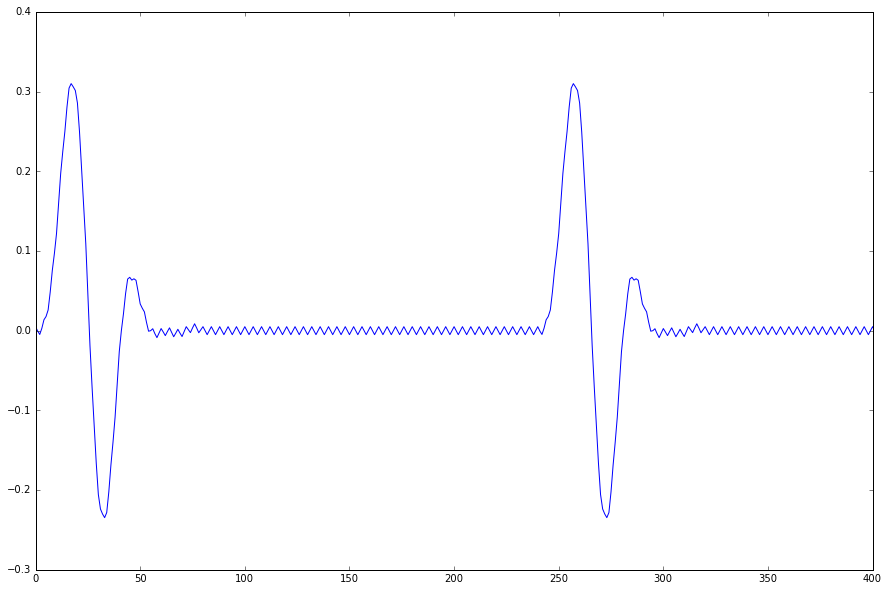

In [39]:
plot(ecg_50)
xlim([0,400])

On va definir un filtre passe-bande, et de la meme maniere que l'on a "inversé" le filtre passe-bas ci-dessus pour obtenir un passe-haut, on pourra obtenir un coupe-bande. 

(0, 400)

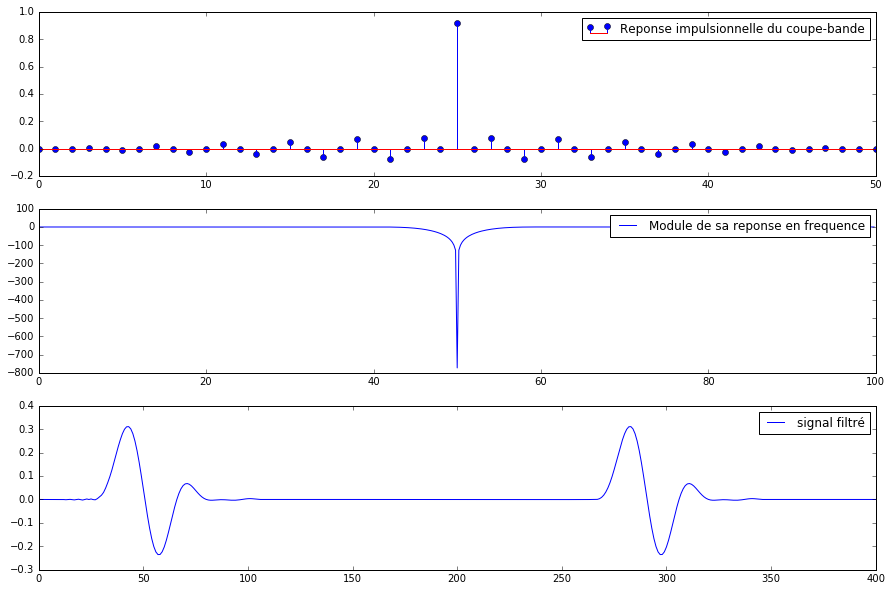

In [57]:
bandpass = sig.firwin(51, [48/(fs/2),52/(fs/2)], pass_zero=False) # cette commande combine un passe-haut et un passe-bas.

# Inversion du passe-bande, pour obtenir un coupe-bande dans la bande [48-52] et ainsi "couper" le 50 Hz
notch50 = - bandpass
notch50[len(notch50)//2] = 1-bandpass[len(notch50)//2]
ecg_no50 = np.convolve(notch50, ecg_50)
w, v = sig.freqz(notch50,1)

subplot(311)
stem(notch50,label='Reponse impulsionnelle du coupe-bande'), legend()
subplot(312)
plot(fs*w/(2*np.pi), 20*log(abs(v)), label='Module de sa reponse en frequence'), legend()
subplot(313)
plot(ecg_no50, label= 'signal filtré'), legend()
xlim([0,400])

## 3. Exemple d'un filtre auto-regréssif d'ordre 1

On rajoute un bruit localise, et on cherche à déterminer l'enveloppe du signal global 

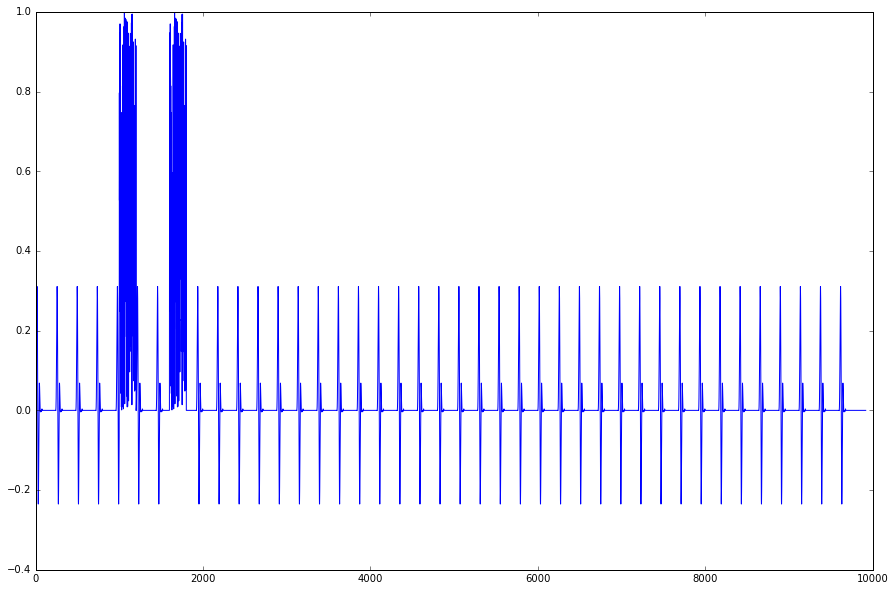

In [60]:
artefact_1sec = np.random.rand( int(1*fs)) # un artefact d'une sec
ecg[5*fs:6*fs] = artefact_1sec # entre 5 et 6 sec
ecg[8*fs:9*fs] = artefact_1sec # entre 8 et 9 sec
plot(ecg)

On va chercher a calculer l'enveloppe du signal pour trouver le bruit. 
Pour cela on mesure l'energie par accumulation dans un reservoir $e(n)$
$e(n) = a e(n-1) + (1-a)  x(n)^2$ avec $0<a<1$

- a trop grand : on remplit trop lentement
- a trop petit : on remplit pas assez
- energie : moyenne ponderee de ce qu'on a et de ce qui arrive

En ecrivant :

$y(n)=\frac{e(n)}{1-a}$ et et $x_2(n) = x(n)^2$ , on trouve : 

$y(n) = ay(n-1) + x_2(n)$


Il s'agit encore d'une convolution : 

$y(n) =x_2(n)+ a x_2(n-1) + \dots + a^n x_2(0)  = \sum_{p=0}^{n} a^p x_2(n-p)$

$h(n) = a^n$, pour $n>=0$

In [61]:
def env(s, a):
    
    e = np.zeros(len(s))
    e[0]=s[0]
    for n in range(1,len(e)):
        e[n] = a * e[n-1] + (1-a) * s[n]**2 # filtre recursif
        
    return e

([<matplotlib.lines.Line2D at 0x1f4982ccf60>],
 <matplotlib.legend.Legend at 0x1f4982baf60>)

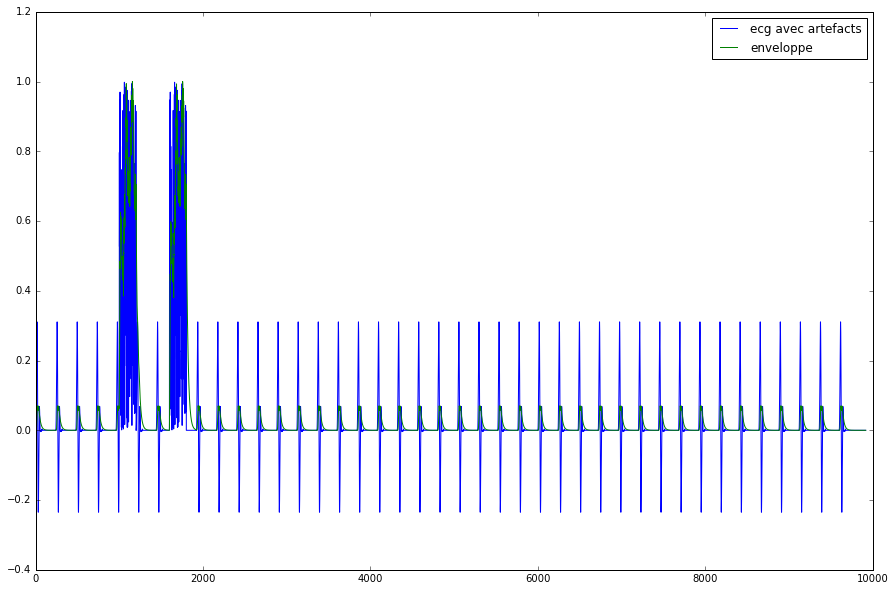

In [70]:
plot(ecg, label='ecg avec artefacts')
plot(env(ecg, 0.95)/max(env(ecg, 0.95)),lw=1, label='enveloppe'), legend()

La sortie du filtre à un temps donné dépend de la valeur de la sortie à un temps précént : il s'agit d'un filtre récursif, et sa fonction de transfert, ici $h(n) = a ^n \mathbb{1}_{[0,+\infty]}(n) $, est inifinie : 

([<matplotlib.lines.Line2D at 0x1f497faa1d0>],
 <matplotlib.legend.Legend at 0x1f497e787f0>)

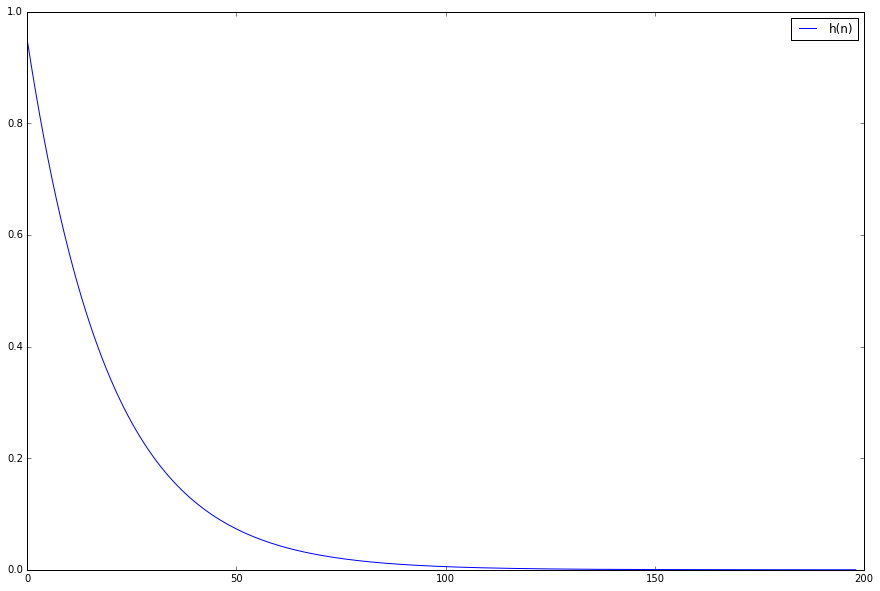

In [71]:
plot([0.95**n for n in np.arange(1,200)], label='h(n)'), legend()

([<matplotlib.lines.Line2D at 0x1f4a0d56588>],
 <matplotlib.text.Text at 0x1f4a0202320>)

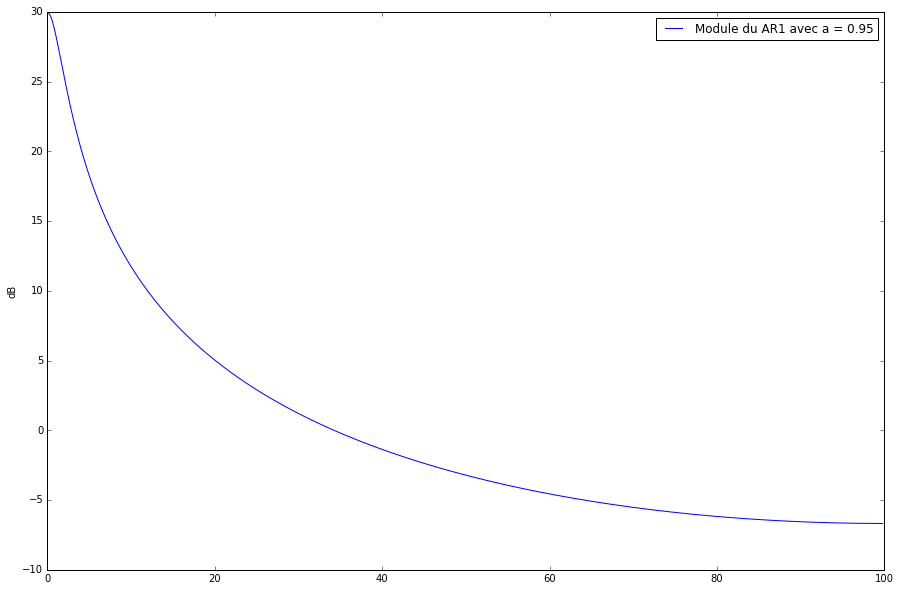

In [104]:
A = np.fft.rfft([0.95**n for n in np.arange(1,200)], NFFT)
w, v = sig.freqz(1,[1,-0.95])
plot(fs*w/(2*np.pi),10*log(abs(v)), label='Module du AR1 avec a = 0.95'), legend(), ylabel('dB')

Le filtre AR1 de parametre a = 0.95 a un effet passe-bas (integrateur)